# Generating with a Different Target Palette (CollaGAN)

In early 2025 I created a new version of CollaGAN that allows for generating images with a different target palette. The model receives as input the source images, target domain and target palette.


In [1]:
import gc
import logging
from time import time

import logging_utils

from ModelProxy import CollaGANModelProxy

logging_utils.configure()

model_loaders = {
    "collagan-pquantize": lambda: CollaGANModelProxy("models/collagan-entcon/lambda-palette-1.0", palette_input=True, domain_dtype="int32"),
    "collagan-perturb-0.5": lambda: CollaGANModelProxy("models/collagan-palette-condition/collagan-perturb-0.5", palette_input=True, domain_dtype="int32"),
}


2025-05-30 14:24:19.494934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 14:24:19.521431: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-30 14:24:19.521479: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 14:24:19.539134: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-30 14:24:20.824671: W tensorflow/compiler/tf

## Loads the Larger Dataset

These tests use the Larger dataset.


In [2]:
from dataset_utils import DatasetLoader


dataset_loader = DatasetLoader("all", "test", limit=None)

In [3]:
import post_process
import tensorflow as tf

def rotate_hue(palettes, max_value=0.5):
    # palette.shape (b, (n), 4)
    # palette is float32 in [-1, 1] range (RGBA)
    batch_size = palettes.shape[0]
    rotated_palettes = []
    for i in range(batch_size):
        current_palette = palettes[i]
        current_palette_alpha = tf.expand_dims(current_palette[..., 3], -1)
        current_palette_rgb = current_palette[..., :3] * 0.5 + 0.5
        current_palette_rgb_as_image = current_palette_rgb[tf.newaxis, ...]
        # current_palette_rgb_as_image.shape (1, n, 3)
        rotated_rgb = tf.image.random_hue(current_palette_rgb_as_image, max_value)
        rotated_rgb = tf.squeeze(rotated_rgb, axis=0)
        rotated_rgb = rotated_rgb * 2. - 1.
        # rotated_rgb.shape (n, 3)
        new_colors = tf.concat([rotated_rgb, current_palette_alpha], axis=-1)
        rotated_palettes.append(new_colors.numpy())
    rotated_palettes = tf.ragged.constant(rotated_palettes, dtype=tf.float32, ragged_rank=1)
    return rotated_palettes

def random_reduce_palette(palettes, percentage=0.25):
    # palette.shape (b, (n), 4)
    # palette is float32 in [-1, 1] range (RGBA)
    # reduces the number of colors in the palette by a percentage
    # it should be a ragged tensor to be returned, as each palette can have a different number of colors
    batch_size = palettes.shape[0]
    reduced_palettes = []
    for i in range(batch_size):
        # defines the number of colors in the palette, and the number in the reduced version
        number_of_colors = tf.shape(palettes[i])[0]
        reduced_number_of_colors = tf.maximum(2, tf.cast(tf.cast(number_of_colors, tf.float32) * percentage, tf.int32))

        current_palette = palettes[i]
        # selects the first colors
        shuffled_palette = tf.random.shuffle(current_palette[1:])
        # shuffled_palette.shape (n-1, 4)
        selected_colors = shuffled_palette[:(reduced_number_of_colors-1)]
        # selected_colors.shape (n-1, 4)
        selected_colors = tf.concat([tf.expand_dims(current_palette[0], 0), selected_colors], axis=0)

        reduced_palettes.append(selected_colors.numpy())
    # creates a ragged tensor from the list of palettes
    reduced_palettes = tf.ragged.constant(reduced_palettes, dtype=tf.float32, ragged_rank=1)
    return reduced_palettes


def random_palette(batch_size, min_colors=10, max_colors=30):
    # palette.shape (b, (n), 4)
    # palette is float32 in [-1, 1] range (RGBA)
    # generates batch_size random palette with [10, 30] colors
    # it should be a ragged tensor to be returned, as each palette can have a different number of colors
    number_of_colors = tf.random.uniform([batch_size], min_colors-1, max_colors-1, dtype=tf.int32)
    palettes = []
    for i in range(batch_size):
        # generates a random palette with number_of_colors[i] colors
        # each color is a random RGB color + 1.0 as alpha
        colors = tf.random.uniform([number_of_colors[i], 3], -1, 1, dtype=tf.float32)
        # adds the alpha channel with 1.0 for all random colors
        colors = tf.concat([colors, tf.ones([number_of_colors[i], 1])], axis=-1)
        # appends a transparent black color at the beginning
        colors = tf.concat([[[-1., -1., -1., -1.]], colors], axis=0)
        palettes.append(colors.numpy())
    # creates a ragged tensor from the list of palettes
    palettes = tf.ragged.constant(palettes, ragged_rank=1, dtype=tf.float32)
    # palette.shape (b, (n), 4)
    return palettes


palettes = [
    [
        [-1., -1., -1., -1.], # transp black
        [0.0, 0.0, 0.0, 1.0], # gray
        [1.0, 1.0, 1.0, 1.0], # white
        [1.0,-1.0,-1.0, 1.0], # red
    ],
    [
        [-1., -1., -1., -1.], # transp black
        [1.0, -1., -1., 1.0], # red
        [-1., 1.0, -1., 1.0], # green
    ]
]
# palettes = tf.ragged.constant(palettes, dtype=tf.float32, ragged_rank=1)
# print("Original", palettes.shape)
# shuffled = tf.map_fn(tf.random.shuffle, palettes)
# print("Shuffled", shuffled)
# hrotated = rotate_hue(palettes)
# print("Hue rotated", hrotated)
# rreduced = random_reduce_palette(palettes)
# print("Reduced.shape", tf.shape(rreduced))
# print("Reduced", rreduced)
# randomized = random_palette(2, min_colors=2, max_colors=5)
# print("Randomized", randomized)


## Generates Images for a Qualitative Analysis


In [4]:
def generate_batch_with_each_model(number_of_4batches=1, sample_numbers=None):
    mode = "random_batch" if sample_numbers is None else "specific_samples"
    if mode == "random_batch":
        # chooses number_of_4batchs*4 indices of examples to load
        sample_numbers = tf.random.uniform([number_of_4batches*4], minval=0, maxval=dataset_loader.dataset_size, dtype=tf.int32)
        print("Sample numbers:", sample_numbers.numpy())
    batch = [dataset_loader.load_paired_images(sample_number) for sample_number in sample_numbers]
    batch = tf.stack(batch, axis=0)
    batch_transpose = batch
    # batch_transpose.shape (b, d, 64, 64, 4)


    target_indices = tf.range(0, 4, dtype=tf.int32)
    dropped_mask = tf.one_hot(target_indices, 4, dtype=tf.float32, off_value=1.0, on_value=0.0)
    source_images = batch_transpose * dropped_mask[..., tf.newaxis, tf.newaxis, tf.newaxis]
    # target_indices = tf.cast(target_indices, tf.float32)

    # generates images with the transformer model with perturbed palettes
    # the target palettes are:
    # 1. the original palette of the source images
    # 2. the original palette, but shuffled
    # 3. a hue rotated version of the palette
    # 4. a palette with only 25% of the colors
    # 5. a palette with completely random colors
    perturbed_model = model_loaders["collagan-perturb-0.5"]()

    original_palettes = post_process.batch_extract_palette_ragged(batch_transpose)
    shuffled_palettes = tf.map_fn(tf.random.shuffle, original_palettes)
    h_rotate_palettes = rotate_hue(original_palettes)
    rreduced_palettes = random_reduce_palette(original_palettes, 0.25)
    randomiz_palettes = random_palette(original_palettes.shape[0])

    INVALID_COLOR = tf.constant([32768., 32768., 32768., 32768.])
    non_ragged_original_palettes = tf.RaggedTensor.to_tensor(original_palettes, default_value=INVALID_COLOR)
    non_ragged_shuffled_palettes = tf.RaggedTensor.to_tensor(shuffled_palettes, default_value=INVALID_COLOR)
    non_ragged_h_rotate_palettes = tf.RaggedTensor.to_tensor(h_rotate_palettes, default_value=INVALID_COLOR)
    non_ragged_rreduced_palettes = tf.RaggedTensor.to_tensor(rreduced_palettes, default_value=INVALID_COLOR)
    non_ragged_randomiz_palettes = tf.RaggedTensor.to_tensor(randomiz_palettes, default_value=INVALID_COLOR)

    original_genned_images = perturbed_model.generate_from_multiple(target_indices, source_images, training=False, target_palette=non_ragged_original_palettes)
    shuffled_genned_images = perturbed_model.generate_from_multiple(target_indices, source_images, training=False, target_palette=non_ragged_shuffled_palettes)
    hrotated_genned_images = perturbed_model.generate_from_multiple(target_indices, source_images, training=False, target_palette=non_ragged_h_rotate_palettes)
    rreduced_genned_images = perturbed_model.generate_from_multiple(target_indices, source_images, training=False, target_palette=non_ragged_rreduced_palettes)
    randomized_genned_images = perturbed_model.generate_from_multiple(target_indices, source_images, training=False, target_palette=non_ragged_randomiz_palettes)

    target_images = tf.gather(batch_transpose, target_indices, batch_dims=1)
    target_palettes = post_process.batch_extract_palette_ragged(target_images)
    del perturbed_model

    # generates images with the baseline model
    baseline_model = model_loaders["collagan-pquantize"]()
    # baseline_model = model_loaders["collagan-baseline"]()
    baseline_genned_images = baseline_model.generate_from_multiple(target_indices, source_images, training=False, target_palette=non_ragged_original_palettes)
    del baseline_model

    baseline_genned_palettes = post_process.batch_extract_palette_ragged(baseline_genned_images)

    return ([
                baseline_genned_images,
                original_genned_images, shuffled_genned_images, hrotated_genned_images, rreduced_genned_images, randomized_genned_images, target_images],
            [
                baseline_genned_palettes,
                original_palettes, shuffled_palettes, h_rotate_palettes, rreduced_palettes, randomiz_palettes, target_palettes],
            [
                "Baseline",
                "Original P.", "Shuffled P.", "Hue Rotated P.", "Fewer colors (25%)", "Random P.", "Ground Truth"])
    

starting_test_sample_numbers = stsn = {"tiny": 0, "rm2k": 136, "rmxp": 168, "rmvx": 212, "misc": 273}
example_numbers=[
    stsn["rmxp"]+25,    # rmxp maid lady
    # stsn["misc"]+782,   #
    stsn["rmxp"]+4,     # rmxp bunny tiara girl
    # stsn["misc"]+207,
    stsn["misc"]+1701,  # misc tiny butt
    # stsn["rm2k"]+20,  #
    stsn["rmxp"]+5,     # rmxp cook
    # stsn["rmvx"]+27,    # rmvx santa

    # stsn["rmvx"]+37,    # rmvx fire warlock
    # stsn["misc"]+1304,  # misc crop knight
    # stsn["rmvx"]+27,    # rmvx santa
]
# imgs_params = generate_batch_with_each_model(1, example_numbers)
imgs_params = generate_batch_with_each_model(1)


Sample numbers: [ 419 1253  891  183]


2025-05-30 14:24:44.340043: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-05-30 14:24:46.764228: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-30 14:24:46.789368: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-30 14:24:47.952874: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.89GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be

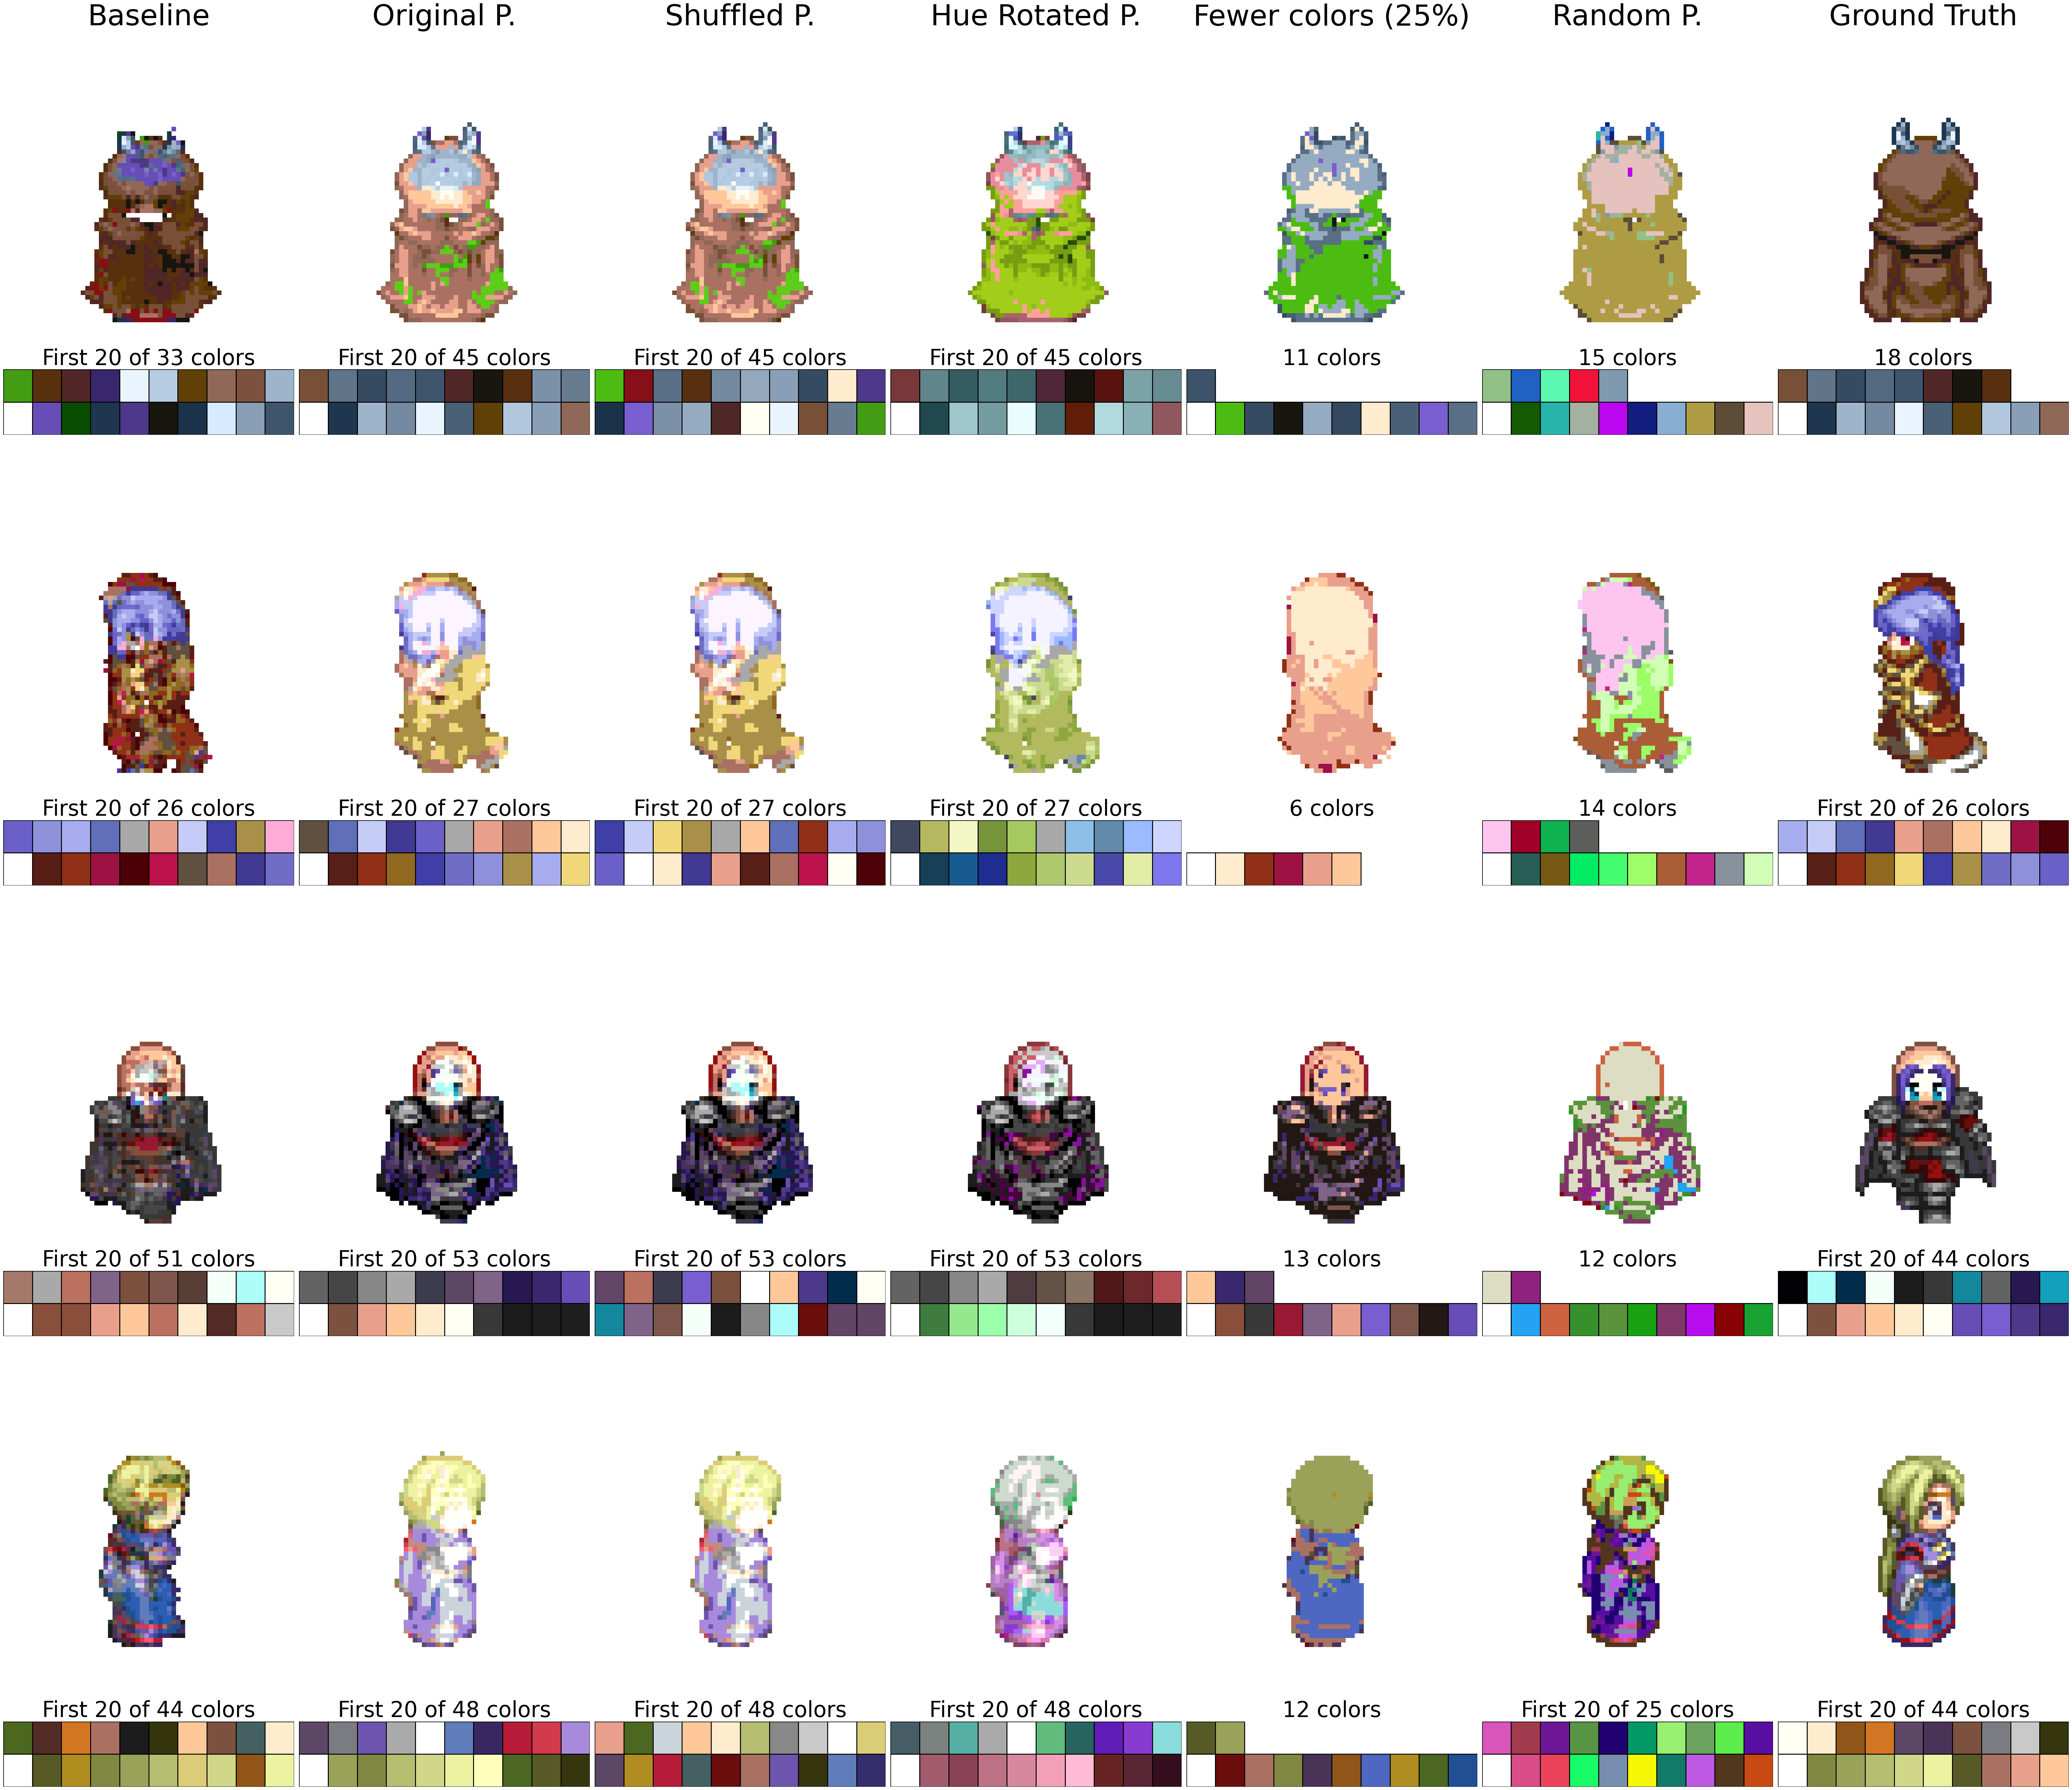

In [5]:
from matplotlib import pyplot as plt

def plot_images(images, palettes, column_titles, sup_title=None):
    palettes = (tf.stack(palettes) + 1.) * 0.5
    # Calculate the number of rows needed (original images + palette rows)
    n_rows = len(images[0]) * 2  # Each image gets its own row and a palette row
    n_cols = len(images)

    fig, axes = plt.subplots(n_rows, n_cols,
                            figsize=(8 * n_rows, 8 * n_cols),
                            gridspec_kw={'height_ratios': [6, 1] * len(images[0])})

    # Flatten axes for easier indexing if it's a 2D array
    if len(images) > 1:
        axes = axes.reshape(-1, len(images))
    else:
        axes = axes.reshape(-1, 1)

    for j, columns in enumerate(images):
        for i, image in enumerate(columns):
            # Image index (accounting for palette rows)
            img_row = i * 2
            palette_row = img_row + 1

            # Show the image
            if i == 0:
                axes[img_row, j].set_title(column_titles[j], fontsize=64)
            axes[img_row, j].imshow(tf.clip_by_value((image + 1) / 2, 0., 1.))
            axes[img_row, j].axis('off')

            # Show the palette below the image
            palette = palettes[j, i]
            num_colors = palette.shape[0]

            # Display first 20 colors or all if less than 20
            typical_num_colors_to_display = 20
            htnctd = half_typical_num_colors_to_display = typical_num_colors_to_display // 2
            num_colors_to_display = min(num_colors, typical_num_colors_to_display)
            display_palette = palette[:num_colors_to_display]
            for k, color in enumerate(display_palette):
                color = tf.clip_by_value(color, 0., 1.)
                swatch = plt.Rectangle(((k%htnctd)/htnctd, (k//htnctd)*0.5), 1/htnctd, 1/2, color=color.numpy(), ec="black", lw=2)
                swatch.set_clip_path(swatch)
                axes[palette_row, j].add_patch(swatch)

            # Set palette title with total number of colors
            if num_colors <= typical_num_colors_to_display:
                palette_title = f"{num_colors} colors"
            else:
                palette_title = f"First {typical_num_colors_to_display} of {num_colors} colors"
            axes[palette_row, j].set_title(palette_title, fontsize=48)
            axes[palette_row, j].axis('off')

    # make the figure have a transparent background
    fig.patch.set_alpha(0.0)
    if sup_title is not None:
        plt.suptitle(sup_title)
    plt.tight_layout()
    plt.show()

plot_images(*imgs_params)